In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import re
import string
import nltk
from collections import Counter
from tqdm.auto import tqdm
from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

c:\Users\glebp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\glebp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glebp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'cuda'

Sentiment analysis

In [2]:
df = pd.read_csv(r'market_comments.csv').dropna()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.day
df.head()

,item_category,item_id,brand,user_id,date,comment,rating,tonality,year
0,401,4010201,826,2217,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",2.0,negative,28
1,403,4030101,1425,1026,2010-07-04,Через 2 месяца после истечении гарантийного ср...,2.0,negative,4
2,401,4010401,124,2769,2010-05-27,пользуюсь уже три недели. нареканий ни каких н...,4.0,positive,27
3,203,2030301,93,508,2016-10-11,Ребят этот системный блок подойдёт для игры кс...,5.0,positive,11
4,205,2050201,656,1049,2010-02-26,"я считаю, что яри замечательный телефон! Прият...",5.0,positive,26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14281 entries, 0 to 14280
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   item_category  14281 non-null  int64         
 1   item_id        14281 non-null  int64         
 2   brand          14281 non-null  int64         
 3   user_id        14281 non-null  int64         
 4   date           14281 non-null  datetime64[ns]
 5   comment        14281 non-null  object        
 6   rating         14281 non-null  float64       
 7   tonality       14281 non-null  object        
 8   year           14281 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(4), object(2)
memory usage: 948.5+ KB


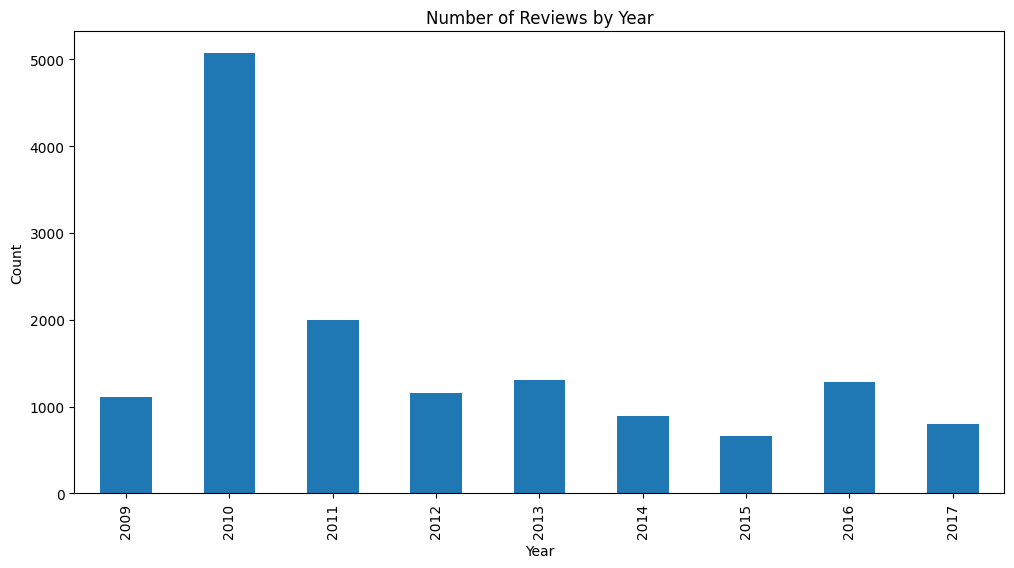

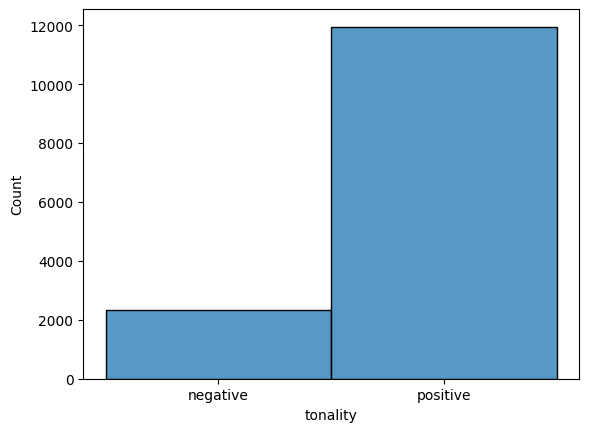

In [4]:
plt.figure(figsize=(12, 6))
df['date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

sns.histplot(df['tonality'])
plt.show()

Data preparation and making custom Dataset

In [5]:
def neg_to_0(ex):
    return (0 if ex=='negative' else 1)
df['tonality'] = df['tonality'].apply(neg_to_0)

In [6]:
def clean_text(text):
    text = text.lower()  
    text = re.sub(f"[{string.punctuation}]", " ", text)  
    text = re.sub(r"\d+", " ", text)  
    words = word_tokenize(text)  
    words = [word for word in words if word not in stopwords.words('russian')]  
    return " ".join(words)

In [7]:
words = Counter()

for example in tqdm(df.comment):
    example = example.lower()
    example = re.sub(f"[{string.punctuation}]", "", example)  
    example = re.sub(r"\d+", "", example)
    for word in word_tokenize(example):
        words[word] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 14281/14281 [00:02<00:00, 5322.50it/s]

Размер словаря: 2653


In [8]:
class WordDataset:
    def __init__(self, data):
        self.data = data
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx):
        processed_text = clean_text(self.data.iloc[idx].comment)
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data.iloc[idx].tonality
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

In [9]:
def collate_fn_with_padding(
        input_batch, pad_id=word2ind['<pad>'], max_len=128):
   
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

Model Training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.comment, df.tonality, test_size=0.2)

train_data = pd.DataFrame({'comment': X_train, 'tonality': y_train})
test_data = pd.DataFrame({'comment': X_test, 'tonality': y_test})

train_dataset = WordDataset(train_data)
val_dataset = WordDataset(test_data)

print(f"Train data shape: {len(train_data)}.\nTest data shape: {len(test_data)}")


Train data shape: 11424.
Test data shape: 2857


In [11]:
class_counts = np.bincount([sample['label'] for sample in train_dataset])
class_weights = 1/class_counts


samples_weights = np.array([sample['label'] for sample in train_dataset])
train_sampler = torch.utils.data.WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

In [12]:
from model import CharLM

In [13]:
from transformers import AutoModel

In [14]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: str, num_labels: int):
        super().__init__()
        
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        return logits

In [15]:
def freeze_backbone_function(model: TransformerClassificationModel, state):
    for param in model.backbone.parameters():
        param.requires_grad = state
    return model

In [16]:
from sklearn.metrics import f1_score

In [22]:
def train_transformer(model, train_loader, val_loader, num_epoch, learning_rate=1e-5, freeze_backbone=True):
    if freeze_backbone:
        freeze_backbone_function(model, False)
    else:
        freeze_backbone_function(model, True)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.train()
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(1, num_epoch+1):
    
        epoch_train_acc = []
        epoch_train_loss = []
        for i, batch in enumerate(tqdm(train_loader)):

            model.train()
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            outp = torch.argmax(logits, dim=1)
            
            acc = int(sum(batch['label'] == outp)) / batch['label'].size(0)
        
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())
            epoch_train_acc.append(acc)
        
        epoch_val_loss = []
        epoch_val_acc = []
        for i, batch in enumerate(tqdm(val_loader)):

            model.eval()
            logits = model(batch['input_ids'])
            outp = torch.argmax(logits, dim=1)
            
            acc = int(sum(batch['label'] == outp)) / batch['label'].size(0)
           
        
            epoch_val_acc.append(acc)
            
        
        epoch_train_loss = np.mean(epoch_train_loss)
        epoch_train_acc = np.mean(epoch_train_acc)
        
        epoch_val_acc = np.mean(epoch_val_acc)
            
        print(F"epoch: {epoch}.\nTrain Loss:{epoch_train_loss}.\nTrain Accuracy:{epoch_train_acc}.\nVal Accuracy{epoch_val_acc}")
        
        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
        val_accuracy.append(epoch_val_acc)


    return model, train_losses, train_accuracy, val_accuracy

In [18]:
BATCH_SIZE = 128
train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, shuffle=True,  batch_size=BATCH_SIZE)

val_dataloader = DataLoader(
    val_dataset, collate_fn=collate_fn_with_padding,shuffle=False, batch_size=BATCH_SIZE)

In [23]:
albert_base_v2_model = TransformerClassificationModel('albert-base-v2', 2).to(device)
albert_base_v2__finetuned_with_freezed_backbone, train_loss, train_acc, val_acc = train_transformer(albert_base_v2_model, train_dataloader,val_dataloader, num_epoch=5, learning_rate=2e-5, freeze_backbone=True)

100%|██████████| 23/23 [01:39<00:00,  4.33s/it]


epoch: 1.
Train Loss:0.6705165776941512.
Train Accuracy:0.6065104166666667.
Val Accuracy0.7903466330858961


100%|██████████| 23/23 [01:39<00:00,  4.32s/it]


epoch: 2.
Train Loss:0.4845744358168708.
Train Accuracy:0.8193576388888889.
Val Accuracy0.8301299045599152


100%|██████████| 23/23 [01:33<00:00,  4.06s/it]


epoch: 3.
Train Loss:0.46231383879979454.
Train Accuracy:0.8293402777777777.
Val Accuracy0.832847295864263


100%|██████████| 23/23 [01:40<00:00,  4.35s/it]


epoch: 4.
Train Loss:0.4593923509120941.
Train Accuracy:0.8309895833333333.
Val Accuracy0.832847295864263


100%|██████████| 23/23 [01:39<00:00,  4.31s/it]

epoch: 5.
Train Loss:0.459127523832851.
Train Accuracy:0.8317708333333333.
Val Accuracy0.83352664369035


In [24]:
res_training = pd.DataFrame({'Train': train_acc, 'Val': val_acc, 'Loss': train_loss})
res_training

,Train,Val,Loss
0,0.606510,0.790347,0.670517
1,0.819358,0.830130,0.484574
2,0.829340,0.832847,0.462314
3,0.830990,0.832847,0.459392
4,0.831771,0.833527,0.459128


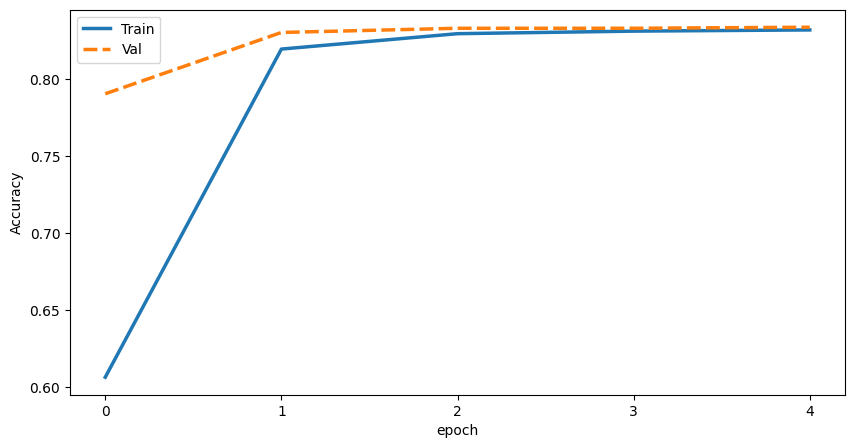

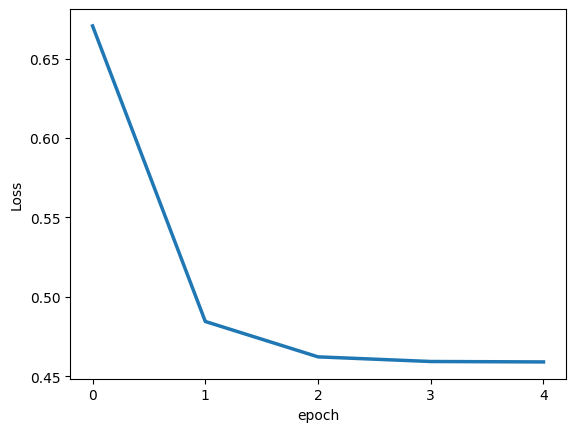

In [25]:
plt.figure(figsize=(10,5))
fig_acc = sns.lineplot(data=res_training.drop(['Loss'], axis=1), linewidth=2.5)
fig_acc.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
fig_acc.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

fig_loss = sns.lineplot(data=res_training['Loss'], linewidth=2.5)
fig_loss.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
fig_loss.set(xlabel='epoch', ylabel='Loss')
plt.show()